# Nepali News Text Classification

### Imports

In [1]:
'''
    Description:
        This program is for document classification written in Nepali language.
    
    Date - 11/10/2018
    
    Author - Oyesh Mann Singh
    
    Tasks to do:
        Work on to merge the labels
        Auto + Bank + Employement + BusinessInterview + Economy
        Interview + Opinion + Literature
    
    Reference - https://github.com/hpanwar08/sentiment-analysis-torchtext/blob/master/Sentiment_Analysis_torchtext.ipynb
'''
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:29:21) 
[GCC 7.3.0]
Pandas version: 0.23.4
Pytorch version: 0.4.0
Torch Text version: 0.3.1
Spacy version: 2.0.16


### Load data

In [3]:
data_root = pathlib.Path('../data/raw/')

classes = ['Auto', 'Bank', 'Blog', 'Business Interview',
           'Economy', 'Education', 'Employment', 'Entertainment',
           'Interview', 'Literature', 'National News', 'Opinion',
           'Sports', 'Technology', 'Tourism', 'World']

In [4]:
df = pd.read_csv('../data/raw/train.csv', error_bad_lines=False)
df.shape
df.head()

(10594, 2)

,label,data
0,10,थारु सभासदहरुले कैलालीको टीकापुरमा भएको झडपमा ...
1,10,राजविराज चैत सप्तरी प्रहरीले पातो गाविसबाट स...
2,1,गजेन्द्र बुढाथोकीकाठमाडौं माघ बैंकिङ क्षेत्र...
3,10,उपप्रधानमन्त्री कमल थापाले संविधानमा असहमति हु...
4,10,असोज काठमाडौं अमेरिकी अधिकारीहरुले आधिकारिक ...


In [5]:
df = df.rename(index=str, columns={"data": "SentimentText", "label": "Sentiment"})

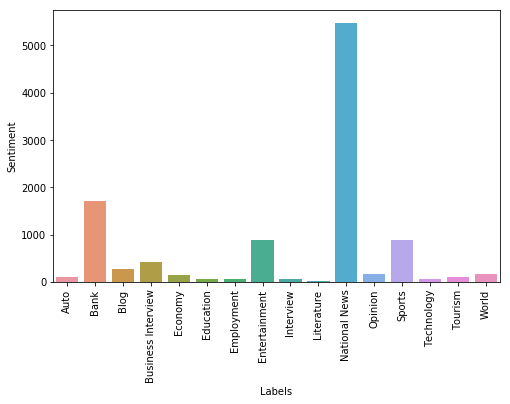

In [6]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(), y=df.Sentiment.value_counts());
ax.set_xticklabels(classes, rotation=90)
ax.set(xlabel='Labels');

## Train validation split

##### torchtext have trouble handling \n. Replace \n character with space.

In [7]:
df['SentimentText'] = df.SentimentText.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████| 10594/10594 [00:00<00:00, 171017.52it/s]


In [8]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [9]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [10]:
traindf.shape
traindf.Sentiment.value_counts()

(8475, 2)

10    4363
12    1365
7      719
4      697
11     342
1      216
2      134
14     126
15     116
6       88
3       84
13      56
5       54
8       53
0       52
9       10
Name: Sentiment, dtype: int64

In [11]:
valdf.shape
valdf.Sentiment.value_counts()

(2119, 2)

10    1111
12     341
4      181
7      162
11      77
1       54
15      37
14      34
2       27
3       24
6       20
0       16
8       12
5       11
13       9
9        3
Name: Sentiment, dtype: int64

##### Save the train and validation df

In [12]:
traindf.to_csv(data_root/'traindf.csv', index=False)
valdf.to_csv(data_root/'valdf.csv', index=False)

## 1. Define how to process data

##### Preprocessing

In [13]:
# nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [14]:
# def tweet_clean(text):
#     text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
#     text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
#     return text.strip()

In [15]:
def tokenizer(s): return s.split()

##### Define fields

In [16]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_val_fields = [
    ('Sentiment', label_field),
    ('SentimentText', txt_field)
]

## 2. Create torchtext dataset

In [17]:
%%time
trainds, valds = data.TabularDataset.splits(path=data_root, format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

CPU times: user 1.14 s, sys: 76 ms, total: 1.22 s
Wall time: 1.21 s


In [18]:
len(trainds), len(valds)

(8475, 2119)

In [19]:
ex = trainds[0]
trainds.fields.items()
# ex.Sentiment
# ex.SentimentText

dict_items([('Sentiment', <torchtext.data.field.Field object at 0x3fff5561a5f8>), ('SentimentText', <torchtext.data.field.Field object at 0x3fff5561a080>)])

In [41]:
ex = valds[0]
ex.SentimentText

['राजविराज',
 'साउन',
 'सप्तरी',
 'जिल्लामा',
 'पहिलो',
 'पटक',
 'आयोजना',
 'हुन',
 'लागेको',
 'युवा',
 'सम्मेलनको',
 'तयारी',
 'अन्तिम',
 'चरणमा',
 'पुगेको',
 'छ',
 'गजेन्द्रनारायण',
 'सिंह',
 'औद्योगिक',
 'क्षेत्रमा',
 'बुधवार',
 'पत्रकार',
 'सम्मेलनको',
 'आयोजना',
 'गरी',
 'कार्यक्रमबारे',
 'जानकारी',
 'दिईएको',
 'हो',
 'आगामी',
 'साउन',
 'र',
 'गते',
 'सप्तरी',
 'युवा',
 'सम्मेलन',
 'गर्न',
 'लागिएको',
 'उक्त',
 'कार्यक्रमको',
 'सम्पूर्ण',
 'तयारी',
 'अन्तिम',
 'चरणमा',
 'पुगिसकेको',
 'सम्मेलन',
 'आयोजक',
 'समितिका',
 'संयोजक',
 'श्रवण',
 'देवले',
 'जानकारी',
 'दिए',
 'सम्मेलन',
 'अघि',
 'हालसम्म',
 'विभिन्न',
 'सरकारी',
 'तथा',
 'गैरसरकारी',
 'निकायका',
 'साथै',
 'युवाहरुसँग',
 'छलफल',
 'तथा',
 'प्रत्येक',
 'क्षेत्रमा',
 'समितिहरु',
 'समेत',
 'गठन',
 'गरिएको',
 'उनले',
 'बताए',
 'सप्तरी',
 'जिल्लाको',
 'गाविसबाट',
 'दुईदुई',
 'र',
 'चार',
 'नगरपालिकाबाट',
 'चारचार',
 'जना',
 'युवा',
 'प्रतिनीधिहरु',
 'सहभागिता',
 'हुने',
 'उनले',
 'जानकारी',
 'दिए',
 'प्रत्येक',
 'गाविस',
 'र',
 '

## 3. Load pretrained word vectors and building vocabulary

In [25]:
%%time
# vec = vocab.Vectors('glove.twitter.27B.100d.txt', './data/glove_embedding/')
vec = vocab.Vectors('../data/ner/nep2vec_text')

100%|█████████▉| 539153/539316 [00:31<00:00, 17110.22it/s]

CPU times: user 33.3 s, sys: 4.05 s, total: 37.4 s
Wall time: 33.8 s


100%|█████████▉| 539153/539316 [00:50<00:00, 17110.22it/s]

In [28]:
%%time
txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)

CPU times: user 2.26 s, sys: 16 ms, total: 2.28 s
Wall time: 2.28 s


In [29]:
txt_field.vocab.vectors.shape

torch.Size([100002, 100])

In [30]:
txt_field.vocab.vectors[txt_field.vocab.stoi['म']]

tensor([-2.1809, -2.9064,  0.2999,  2.0110,  0.4456, -1.9149,  2.5928,
         0.4759, -3.5168, -1.7228,  0.9689, -1.1807,  1.2251,  1.5143,
         0.2402,  0.7863,  1.8475,  1.4941, -1.8930,  0.9076, -2.8261,
         2.1876, -0.3402,  5.4560,  2.8103, -0.7420,  2.4383, -3.1116,
        -4.5566, -2.2779, -1.9585,  2.8425,  0.1013, -1.9101, -0.8738,
         1.4721, -1.8572, -2.3011,  1.7271,  1.7833, -1.3904, -1.2532,
         1.6021, -1.7275, -0.3048, -0.2916,  0.4738,  1.4575, -2.0842,
         4.7013,  1.9108,  3.2337, -0.6426,  0.7547, -0.2982, -0.3934,
         0.0745, -0.0009, -0.6721,  0.5823,  0.1119,  2.0588, -2.2671,
         2.2146, -2.7261, -0.2615, -2.1634,  1.0676,  2.4389,  3.0188,
        -1.3422, -0.8430,  1.9157, -1.0331,  2.1610,  2.0938,  2.5880,
         2.2489, -2.0876,  0.3517,  0.7181,  0.8557, -0.3567,  1.6973,
         0.9724, -1.7851,  1.9660, -1.3585, -1.0752,  0.0231,  3.3223,
         1.6451, -0.5706,  3.7812,  0.0932, -0.6909, -3.2804, -4.7514,
      

## 4. Loading the data in batches

In [31]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(3,3), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=None, 
                                            sort_within_batch=True, 
                                            repeat=False)

In [32]:
len(traindl), len(valdl)

(2825, 707)

In [35]:
batch = next(iter(traindl))
type(traindl)

torchtext.data.iterator.BucketIterator

In [36]:
batch.Sentiment

tensor([ 10,  10,  10])

##### returns word indices and lengths

In [37]:
batch.SentimentText

(tensor([[   228,  65938,   3379],
         [   608,  66171,   5836],
         [  3161,   5380,      0],
         [ 23522,  12794,    473],
         [  3855,     72,     24],
         [ 14097,    451,  32737],
         [ 22190,     41,    689],
         [  8800,   4300,     24],
         [    23,    983,   5532],
         [   302,    986,   1147],
         [  8328,    301,  22335],
         [     3,     56,   1316],
         [  5598,     32,   2308],
         [  5844,   3151,   4360],
         [    36,  40149,    439],
         [   448,    538,   1948],
         [    19,  27302,   9544],
         [     5,    226,   1796],
         [   249,  41486,   1578],
         [  3855,  66171,   3973],
         [  1740,      0,   2163],
         [     8,   1392,     15],
         [ 39513,   1106,   2190],
         [  8800,   2294,  12930],
         [   151,  16612,    432],
         [   573,   3697,    110],
         [   448,      3,    209],
         [    28,  18713,      6],
         [   608,   

In [38]:
batch.dataset.fields

{'Sentiment': <torchtext.data.field.Field at 0x3fff5561a5f8>,
 'SentimentText': <torchtext.data.field.Field at 0x3fff5561a080>}

In [39]:
txt_field.vocab.itos[1]

'<pad>'

##### convert index to string

Function to convert batch to text

In [32]:
def idxtosent(batch, idx):
    return ' '.join([txt_field.vocab.itos[i] for i in batch.SentimentText[0][:,idx].cpu().data.numpy()])

In [33]:
idxtosent(batch,0)

'भदौ काठमाडौं गोर्खा र धादिङमा मुलुकको विकासको ढोका खोल्ने सय मेगावाटको बुढीगण्डकी जलविद्युत आयोजना बन्दैछ आजसम्म देशभित्र हामीले नदेखेको यति ठूलो आयोजना कस्तो होला हेर्नुहोस् बुढीगण्डकी जलविद्युत आयोजना विकास समितिले तयार पारेको थ्री डी मोडल <unk> छन् आयोजनाका विशेषता <unk> गुणा ठूलो <unk> यो आयोजना निर्माण गर्दा मिटर अग्लो बाँध बाँधिने छ बाँध बाँधेपछि बन्ने ताल पोखराको फेवातालभन्दा गुणा ठूलो हुने आयोजनाका कार्यकारी निर्देशक बस्नेतले जानकारी दिए तालमा पानीको गहिराइ मिटरको हुन्छ यति ठूलो ताल बन्ने भएपछि यसलाई पर्यटकीय क्षेत्रका रुपमा विकास गर्न सकिने उनको भनाइ छ दुई सय किलोमिटरको <unk> विकास समितिले आयोजना प्रभावित क्षेत्रमा रिङरोड बनाउन प्रस्ताव गरेको छ समितिका कार्यकारी निर्देशक बस्नेतका अनुसार अहिले आयोजना प्रभावित क्षेत्रमा सय मिलोमिटर लामो रिङरोड निर्माण गर्न सर्भेक्षणको काम भइरहेको छ रिङरोड धादिङ र गोर्खाका गाविसमा हुनेछ रिङरोड बनिसकेपछि त्यस क्षेत्रको आर्थिक तथा सामाजिक विकासमा ठूलो योगदान पुग्ने उनले बताए विस्थापित परिवारको संख्या <unk> यो आयोजना बन्दा हजार जनसंख्या पूर्णरुपमा 

In [34]:
val_batch = next(iter(valdl))

##### Note that BucketIterator returns a Batch object instead of text index and labels directly and Batch object is not iterable unlike pytorch Dataloader. A single Batch object contains the data of one batch and the text and labels can be accessed via column names. 
##### This is one of the small hiccups in torchtext. But this can be easily overcome in two ways. Either write some extra code in the training loop for getting the data out of Batch object or write a iterable wrapper around Batch Object that returns the desired data. I will take the second approach as this is much cleaner.

In [35]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [36]:
train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')

## 5. Finally Model and training

In [37]:
vocab_size = len(txt_field.vocab)
embedding_dim = 100
n_hidden = 64
n_out = len(classes)

## Simple RNN module

#### Simple GRU model

In [38]:
class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out,self.bidirectional = vocab_size, embedding_dim, n_hidden, n_out, bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        gru_out, self.h = self.gru(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        gru_out, lengths = pad_packed_sequence(gru_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

#### RNN Model

In [39]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.rnn = nn.RNN(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        rnn_out, self.h = self.rnn(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        rnn_out, lengths = pad_packed_sequence(rnn_out) # pad the sequence to the max length in the batch
        # since it is as classification problem, we will grab the last hidden state
        outp = self.out(self.h[-1]) # self.h[-1] contains hidden state of last timestep
#         return F.log_softmax(outp, dim=-1)
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).to(device)

#### LSTM Model

In [40]:
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1) # batch size
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs) # initialize hidden state of GRU
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths) # unpad
        lstm_out, self.h = self.lstm(embs, self.h) # gru returns hidden state of all timesteps as well as hidden state at last timestep
        lstm_out, lengths = pad_packed_sequence(lstm_out) # pad the sequence to the max length in the batch
        outp = self.out(self.h[0][-1]) # self.h[-1] contains hidden state of last timestep
        return F.log_softmax(outp)
        
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            h0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
        else:
            h0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
        return (h0, c0)

#### Concat Pooling model

In [41]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        if bidirectional:
            self.out = nn.Linear(self.n_hidden*2*2, self.n_out)
        else:
            self.out = nn.Linear(self.n_hidden*2, self.n_out)
        
    def forward(self, seq, lengths):
        bs = seq.size(1)
        self.h = self.init_hidden(bs)
        seq = seq.transpose(0,1)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(bs,-1)        
        outp = self.out(torch.cat([avg_pool,max_pool],dim=1))
        return F.log_softmax(outp)
    
    def init_hidden(self, batch_size): 
        if self.bidirectional:
            return torch.zeros((2,batch_size,self.n_hidden)).to(device)
        else:
            return torch.zeros((1,batch_size,self.n_hidden)).cuda().to(device)

#### Training function

In [42]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc = []
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for (X,lengths),y in t:
            t.set_description(f'Epoch {epoch}')
            lengths = lengths.cpu().numpy()
            
            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X,lengths),y in tqdm_notebook(val_dl, leave=False):
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')
        total_val_loss.append(valloss)
        total_val_acc.append(valacc)
            
    return model, total_train_loss, total_train_acc, total_val_loss, total_val_acc

##### Dataloader

In [43]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds), 
                                            batch_sizes=(512,1024), 
                                            sort_key=lambda x: len(x.SentimentText), 
                                            device=device, 
                                            sort_within_batch=True, 
                                            repeat=False)

train_batch_it = BatchGenerator(traindl, 'SentimentText', 'Sentiment')
val_batch_it = BatchGenerator(valdl, 'SentimentText', 'Sentiment')

#### Plot loss

In [44]:
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=[8,5])
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

#### REVIEW PREDICTION

In [45]:
# Testing with random new review
review = ["सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।",
         "आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।",
         "बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। "]

# Print the prediction of new reviews
def print_prediction(review=review, model=None):
    for each_review in review:
        original_review = each_review
        each_review = txt_field.preprocess(each_review)
        each_review = [[txt_field.vocab.stoi[x] for x in each_review]]
        each_review = np.asarray(each_review)
        each_review = Variable(torch.LongTensor(each_review), volatile=True).to(device)
        model.eval()
        output = model(each_review, torch.ones((len(each_review[0])), dtype=torch.long))
        label = torch.argmax(output[0])
        print("{0}: {1}\n".format(original_review, classes[label]))

#### LOAD/SAVE MODEL

In [46]:
def save_checkpoint(model, train_loss, train_acc, val_loss, val_acc, filename):
    save_parameters = {'model': model,
                      'train_loss' : train_loss,
                      'train_acc' : train_acc,
                      'val_loss' : val_loss,
                      'val_acc' : val_acc}
    torch.save(save_parameters, filename)
    
    
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    
    model = checkpoint['model']
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_loss = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']
    
    return model, train_loss, train_acc, val_loss, val_acc

#### GRU SECTION

In [47]:
gru_model = SimpleGRU(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, gru_model.parameters()), 1e-3)
gru_model_file = './data/models/gru_model.pth'

In [48]:
if os.path.exists(gru_model_file):
    gru_model, gru_train_loss, gru_train_acc, gru_val_loss, gru_val_acc = load_checkpoint(gru_model_file)
else:
    gru_model, gru_train_loss, gru_train_acc, gru_val_loss, gru_val_acc = fit(model=gru_model, train_dl=train_batch_it, 
                                                                       val_dl=val_batch_it, loss_fn=F.nll_loss, 
                                                                       opt=opt, epochs=40)

In [49]:
save_checkpoint(gru_model, gru_train_loss, gru_train_acc, gru_val_loss, gru_val_acc, gru_model_file)

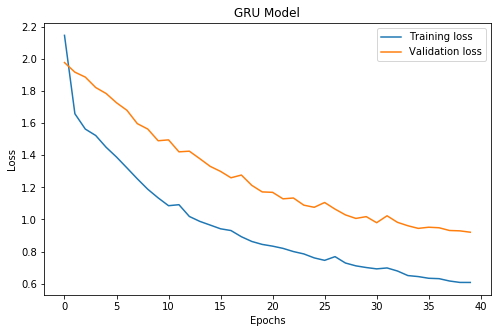

In [50]:
plot_loss(gru_train_loss, gru_val_loss, title='GRU Model')

In [51]:
print_prediction(review=review, model=gru_model)

सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Sports

आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports

बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports



In [52]:
print("GRU Validation accuracy", gru_val_acc[-1])

GRU Validation accuracy 0.7744218971212836


#### RNN SECTION

In [53]:
rnn_model = SimpleRNN(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, rnn_model.parameters()), 1e-3)

rnn_model_file = './data/models/rnn_model.pth'

if os.path.exists(rnn_model_file):
    rnn_model, rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc = load_checkpoint(rnn_model_file)
else:
    rnn_model, rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc = fit(model=rnn_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=40)

Epoch 0: train_loss: 2.1983 train_acc: 0.4081 | val_loss: 1.9772 val_acc: 0.5262


Epoch 1: train_loss: 1.6905 train_acc: 0.5173 | val_loss: 1.9251 val_acc: 0.5286


Epoch 2: train_loss: 1.5813 train_acc: 0.5370 | val_loss: 1.9051 val_acc: 0.5569


Epoch 3: train_loss: 1.5397 train_acc: 0.5490 | val_loss: 1.8699 val_acc: 0.5687


Epoch 4: train_loss: 1.4950 train_acc: 0.5663 | val_loss: 1.8516 val_acc: 0.5757


Epoch 5: train_loss: 1.4632 train_acc: 0.5771 | val_loss: 1.8773 val_acc: 0.5724


Epoch 6: train_loss: 1.4238 train_acc: 0.5763 | val_loss: 1.8209 val_acc: 0.5913


Epoch 7: train_loss: 1.3977 train_acc: 0.5912 | val_loss: 1.7444 val_acc: 0.5989


Epoch 8: train_loss: 1.3555 train_acc: 0.5943 | val_loss: 1.7326 val_acc: 0.6069


Epoch 9: train_loss: 1.3279 train_acc: 0.6109 | val_loss: 1.6889 val_acc: 0.6196


Epoch 10: train_loss: 1.2941 train_acc: 0.6126 | val_loss: 1.7081 val_acc: 0.5965


Epoch 11: train_loss: 1.2867 train_acc: 0.6057 | val_loss: 1.6287 val_acc: 0.6253


Epoch 12: train_loss: 1.2397 train_acc: 0.6245 | val_loss: 1.5941 val_acc: 0.6310


Epoch 13: train_loss: 1.2153 train_acc: 0.6347 | val_loss: 1.5828 val_acc: 0.6343


Epoch 14: train_loss: 1.2069 train_acc: 0.6353 | val_loss: 1.6029 val_acc: 0.6418


Epoch 15: train_loss: 1.1674 train_acc: 0.6483 | val_loss: 1.5518 val_acc: 0.6479


Epoch 16: train_loss: 1.1641 train_acc: 0.6500 | val_loss: 1.5520 val_acc: 0.6319


Epoch 17: train_loss: 1.1688 train_acc: 0.6425 | val_loss: 1.5088 val_acc: 0.6527


Epoch 18: train_loss: 1.1484 train_acc: 0.6476 | val_loss: 1.5681 val_acc: 0.6479


Epoch 19: train_loss: 1.1710 train_acc: 0.6394 | val_loss: 1.5721 val_acc: 0.6159


Epoch 20: train_loss: 1.1794 train_acc: 0.6335 | val_loss: 1.4801 val_acc: 0.6536


Epoch 21: train_loss: 1.1268 train_acc: 0.6558 | val_loss: 1.4863 val_acc: 0.6654


Epoch 22: train_loss: 1.0998 train_acc: 0.6630 | val_loss: 1.5412 val_acc: 0.6579


Epoch 23: train_loss: 1.1161 train_acc: 0.6564 | val_loss: 1.4930 val_acc: 0.6588


Epoch 24: train_loss: 1.1091 train_acc: 0.6608 | val_loss: 1.4747 val_acc: 0.6630


Epoch 25: train_loss: 1.0721 train_acc: 0.6702 | val_loss: 1.4617 val_acc: 0.6692


Epoch 26: train_loss: 1.0606 train_acc: 0.6742 | val_loss: 1.4302 val_acc: 0.6673


Epoch 27: train_loss: 1.0512 train_acc: 0.6779 | val_loss: 1.4117 val_acc: 0.6645


Epoch 28: train_loss: 1.0411 train_acc: 0.6782 | val_loss: 1.4385 val_acc: 0.6706


Epoch 29: train_loss: 1.0489 train_acc: 0.6781 | val_loss: 1.4217 val_acc: 0.6730


Epoch 30: train_loss: 1.0328 train_acc: 0.6805 | val_loss: 1.4553 val_acc: 0.6739


Epoch 31: train_loss: 1.0268 train_acc: 0.6850 | val_loss: 1.4184 val_acc: 0.6489


Epoch 32: train_loss: 1.0313 train_acc: 0.6759 | val_loss: 1.4550 val_acc: 0.6687


Epoch 33: train_loss: 1.0485 train_acc: 0.6753 | val_loss: 1.4533 val_acc: 0.6767


Epoch 34: train_loss: 1.0370 train_acc: 0.6779 | val_loss: 1.4161 val_acc: 0.6777


Epoch 35: train_loss: 1.0363 train_acc: 0.6821 | val_loss: 1.4393 val_acc: 0.6767


Epoch 36: train_loss: 1.0352 train_acc: 0.6787 | val_loss: 1.4903 val_acc: 0.6357


Epoch 37: train_loss: 1.0172 train_acc: 0.6838 | val_loss: 1.3728 val_acc: 0.6805


Epoch 38: train_loss: 0.9997 train_acc: 0.6898 | val_loss: 1.3564 val_acc: 0.6673


Epoch 39: train_loss: 0.9897 train_acc: 0.6933 | val_loss: 1.3868 val_acc: 0.6819



In [54]:
save_checkpoint(rnn_model, rnn_train_loss, rnn_train_acc, rnn_val_loss, rnn_val_acc, rnn_model_file)

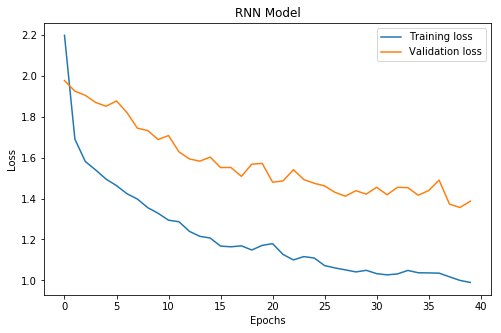

In [55]:
plot_loss(rnn_train_loss, rnn_val_loss, title='RNN Model')

In [56]:
print("RNN Validation accuracy", rnn_val_acc[-1])

RNN Validation accuracy 0.6819254365266635


In [57]:
print_prediction(model=rnn_model)

सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Sports

आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Sports

बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Sports



#### ConcatPoolingGRUAdaptive Section

In [58]:
gru_a_model = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, gru_a_model.parameters()), 1e-3)

gru_a_model_file = './data/models/gru_a_model.pth'

if os.path.exists(gru_a_model_file):
    gru_a_model, gru_a_train_loss, gru_a_train_acc, gru_a_val_loss, gru_a_val_acc = load_checkpoint(gru_a_model_file)
else:
    gru_a_model, gru_a_train_loss, gru_a_train_acc, gru_a_val_loss, gru_a_val_acc = fit(model=gru_a_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=40)

In [59]:
save_checkpoint(gru_a_model, gru_a_train_loss, gru_a_train_acc, gru_a_val_loss, gru_a_val_acc, gru_a_model_file)

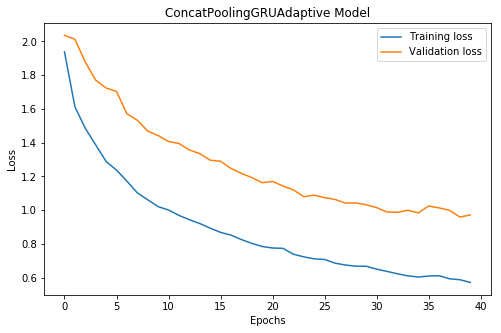

In [60]:
plot_loss(gru_a_train_loss, gru_a_val_loss, title='ConcatPoolingGRUAdaptive Model')

In [61]:
print_prediction(model=gru_a_model)

सत्ताधारी नेपाल कम्युनिस्ट पार्टी (नेकपा) का प्रवक्ताले निकै विवादित बन्न पुगेको एशिया प्यासिफिक सम्मेलन हुने कुरा चल्दा नै आफूले पार्टीभित्र आपत्ति जनाए पनि सुनुवाइ नभएको बताएका छन्।: Sports

आयोजनामा ट्वान्टी–२० क्रिकेट प्रतिगोगिता बुधबारदेखि सुरु भएको छ। महाराजगञ्जस्थित पाकिस्तान दूतावासको क्रिकेट ग्राउन्डमा भएको प्रतियोगिताको काठमाडौं महानगरपालिकाका मेयर विद्यासुन्दर शाक्यले उद्घाटन गरेका थिए।: Bank

बोर्डले यसलाई ऐतिहासिक उपलब्धी भनेको छ। यो संख्या अघिल्लो वर्ष सन् २०१७को भन्दा १७ प्रतिशतले बढी हो। यो तथ्यांकमा अक्टोबर र नोभेम्बरमा पैदलमार्गबाट आएका पर्यटकको संख्या सामेल छैन । यो संख्या पनि जोड्दा जनवरीदेखि नोभेम्बरसम्ममा नै करिब २३ प्रतिशत वृद्धि देखिने बोर्डको आंकलन छ। : Bank



In [62]:
print("ConcatPoolingGRUAdaptive Validation accuracy", gru_a_val_acc[-1])

ConcatPoolingGRUAdaptive Validation accuracy 0.729589428975932


#### LSTM SECTION

In [64]:
lstm_model = SimpleLSTM(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['SentimentText'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), 1e-3)
lstm_model_file = './data/models/lstm_model.pth'

if os.path.exists(lstm_model_file):
    lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = load_checkpoint(lstm_model_file)
else:
    lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = fit(model=lstm_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=40)

In [65]:
save_checkpoint(lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc, lstm_model_file)

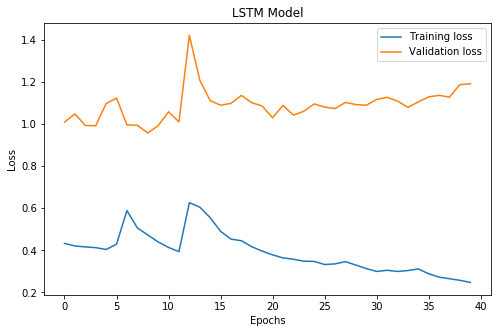

In [66]:
plot_loss(lstm_train_loss, lstm_val_loss, title='LSTM Model')

In [67]:
new_review = ["मेक्सिकोबाट बाबु र अरु दर्जनौं व्यक्तिसँगै गैरकानुनी रुपमा अमेरिका प्रवेश गरेकी ती बालिकाको शरीरमा पानीको मात्रा कम हुने समस्याबाट मृत्यु भएको अमेरिकी भन्सार तथा सीमा सुरक्षा निकायले जनाएको छ । उक्त निकायले ती बालिकाले धेरै दिनदेखि केही नखाएको र पानी समेत नपिएको बताएको छ । पक्राउ परेलगत्तै त्रसित मुद्रामा देखिएकी ती बालिकामा एकाएक काँप्ने समस्या देखिएको, र उपचारका लागि स्थानीय अस्पतालमा पुर्‍याएलगत्तै मृत्यु भएको सीमा सुरक्षा निकायले जनाएको छ । राष्ट्रपति डोनाल्ड ट्रम्पले मेक्सिकोबाट अमेरिका प्रवेश गर्न खोज्ने व्यक्तिलाई अवैध आप्रवासीको संज्ञा दिँदै उनीहरुलाई अमेरिका प्रवेश गरेमा पक्राउ गरी फर्काइदिने चेतावनी दिएका छन् । उनले हजारौं अमेरिकी सुरक्षा फौजलाई मेक्सिकोसँगको सीमामा तैनाथ गरेका छन् । "]

print_prediction(review = new_review, model=lstm_model)

मेक्सिकोबाट बाबु र अरु दर्जनौं व्यक्तिसँगै गैरकानुनी रुपमा अमेरिका प्रवेश गरेकी ती बालिकाको शरीरमा पानीको मात्रा कम हुने समस्याबाट मृत्यु भएको अमेरिकी भन्सार तथा सीमा सुरक्षा निकायले जनाएको छ । उक्त निकायले ती बालिकाले धेरै दिनदेखि केही नखाएको र पानी समेत नपिएको बताएको छ । पक्राउ परेलगत्तै त्रसित मुद्रामा देखिएकी ती बालिकामा एकाएक काँप्ने समस्या देखिएको, र उपचारका लागि स्थानीय अस्पतालमा पुर्‍याएलगत्तै मृत्यु भएको सीमा सुरक्षा निकायले जनाएको छ । राष्ट्रपति डोनाल्ड ट्रम्पले मेक्सिकोबाट अमेरिका प्रवेश गर्न खोज्ने व्यक्तिलाई अवैध आप्रवासीको संज्ञा दिँदै उनीहरुलाई अमेरिका प्रवेश गरेमा पक्राउ गरी फर्काइदिने चेतावनी दिएका छन् । उनले हजारौं अमेरिकी सुरक्षा फौजलाई मेक्सिकोसँगको सीमामा तैनाथ गरेका छन् । : National News



In [68]:
print("LSTM Validation accuracy", lstm_val_acc[-1])

LSTM Validation accuracy 0.7663992449268523
